# EXC RB simulation

Luca Mechelli, Tim Keil

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	 ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= c_{\mu}(u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](../../EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](../../EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_D}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i (\mu_i-\mu_i^d)^2 + 1,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i (\mu_i-\mu_i^d)^2 + \frac{\sigma_D}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}  + 1\\
j_{\mu}(u) & = -\sigma_D \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,v) &= \frac{\sigma_D}{2} \int_{D}^{} u\,v 
\end{align}

The following code implements this particular case.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [2]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../../../EXC_data'

# domain of interest
bounding_box = [[0,0],[2,1]]
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition

In [3]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg

parametric_quantities = {'walls': [1,4,9], 'windows': [], 'doors': [], 'heaters': [1,3,5,6,7,8,9]}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [1,2,3,4,5,6,7,10], 'active_heaters': []}
summed_quantities = {'walls': [[1,2,3,8],[4,5,6,7]], 'windows': [], 'doors': [], 'heaters': [[1,2],[3,4],[9,10,11,12]]}

coefficient_expressions = None

parameters_in_q = True
input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.025,0.1], iwc= [0.025,0.1], idc=[0.005], wc=[0.0005], ht=[0,100],
                                    owc_c=0.001,  iwc_c= 0.025,     idc_c=0.01,  wc_c=0.025,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)

u_d = 18 

mu_d = None 

sigma_d = 100
weights = {'walls': [0.5,0.25,0.05], 'doors': 1, 'heaters': [0.002,0.002,0.001,0.001,0.001,0.001,0.004], 'windows': 1, 'state': sigma_d}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy',
                                                          use_corrected_gradient= True)

I am using the corrected functional!!
I am using the corrected gradient!!
{heaters: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], walls: [0.049999999999999996, 0.049999999999999996, 0.049999999999999996]}
my product is fixed_energy


In [4]:
print('information on the grid:')
print(data['grid'])

radius = 0.1               # TR radius 
FOC_tolerance = 5e-4       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 40                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)

information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


Now we pick one specific starting parameter

In [5]:
# starting with
mu = problem.parameter_space.sample_randomly(1, seed= 2)[0]
print(mu)

{heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}


## Visualizations

Visualize the position of left- and right-hand sides parameters

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f36fc796ad0>

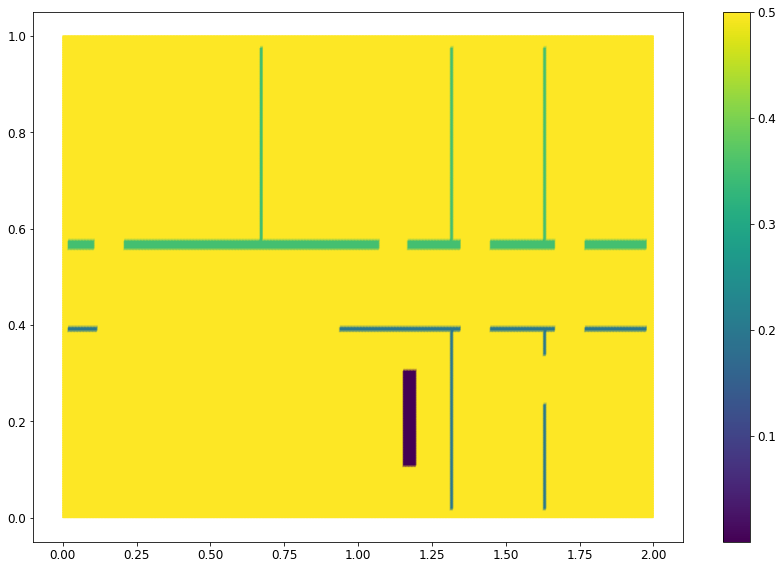

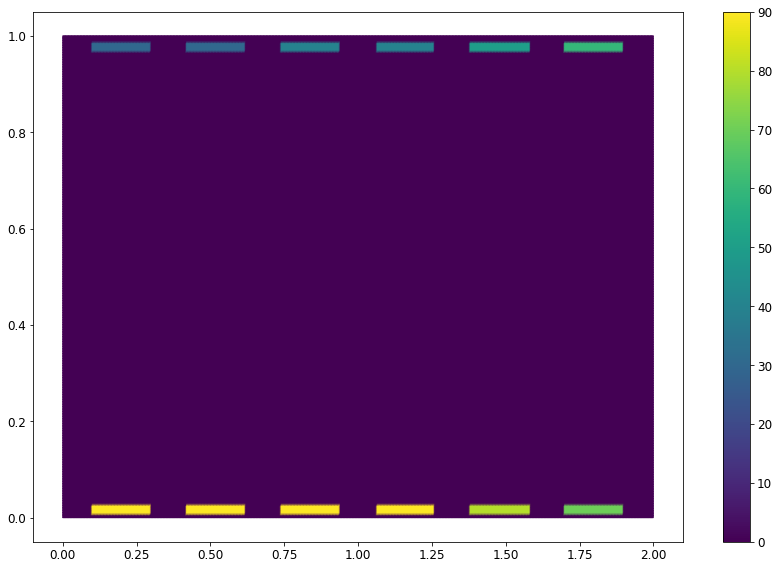

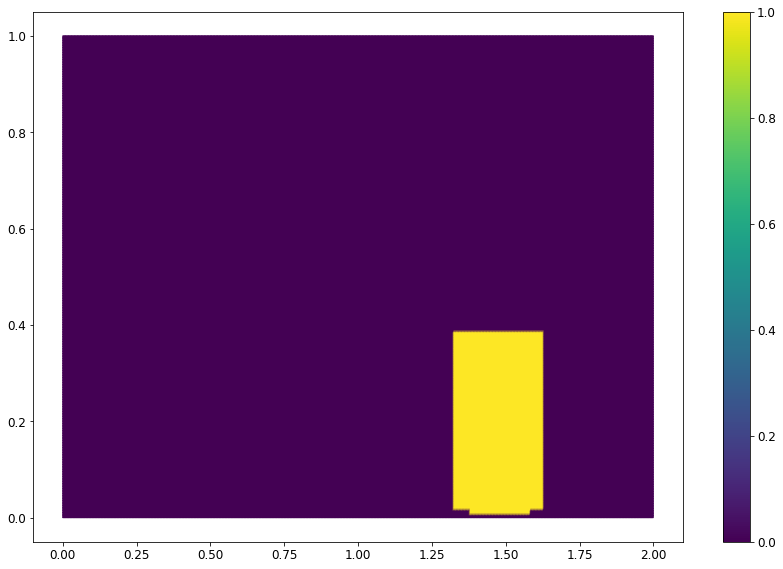

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = problem.parameter_space.sample_randomly(1, seed= 13)[0]
vis_mu['walls'][0] = 0.35
vis_mu['walls'][1] = 0.2
vis_mu['walls'][2] = 0.0001
vis_mu['heaters'][0] = 30
vis_mu['heaters'][1] = 40
vis_mu['heaters'][2] = 50
vis_mu['heaters'][3] = 60
vis_mu['heaters'][4] = 70
vis_mu['heaters'][5] = 80
vis_mu['heaters'][6] = 90
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)
opt_fom.visualize(diff)
opt_fom.visualize(rhs)
#plt.savefig('exc_2_rhs.pdf', format='pdf', bbox_inches="tight")
opt_fom.visualize(doI)

We can easily solve the primal and dual equations by calling 

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f3702e135d0>

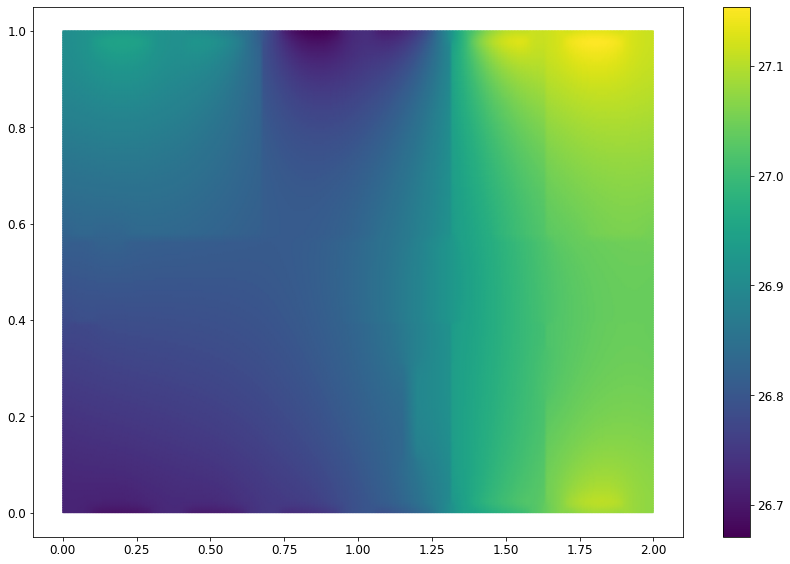

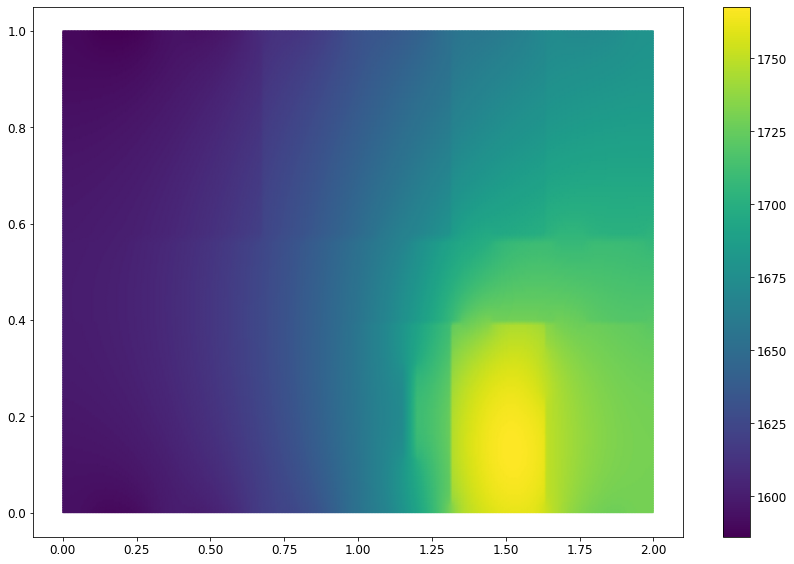

In [7]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)
opt_fom.visualize(p)

# Full Order Optimization

In [8]:
mu_opt = opt_fom.parse_parameter(opt_fom.pre_parse_parameter([1.651891986460e+01, 1.692820877511e+01, 1.732387911116e+01, 1.746951227840e+01, 
                                                                 1.812299797114e+01, 1.840759241105e+01, 1.693448657882e+01, 2.500000000000e-02, 
                                                                 2.500000000000e-02, 2.500000000000e-02]))
mu_opt_as_array = opt_fom.parse_parameter_inverse(mu_opt)
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', opt_fom.parse_parameter_inverse(mu))
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [16.51891986 16.92820878 17.32387911 17.46951228 18.12299797 18.40759241
 16.93448658  0.025       0.025       0.025     ]
Optimal J:  2.772773184915195

Starting parameter:  [4.35994902e+01 2.59262318e+00 5.49662478e+01 4.35322393e+01
 4.20367802e+01 3.30334821e+01 2.04648634e+01 7.14453225e-02
 4.74741005e-02 4.50120456e-02]
Starting J:  478.30364382819425


## FOM BFGS

In [9]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors, compute_actual_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True }


muoptfom,_,_,_, times_2, mus_2, Js_2, FOC_2 = solve_optimization_subproblem_BFGS(opt_fom,opt_fom.parameter_space,mu,TR_parameters, timing=True)
times_full_2, J_error_2, mu_error_2 = compute_errors(opt_fom, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_2, Js_2, times_2, 0)

Starting parameter {heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}
Step [30.76538361  0.         48.2605672  36.79185133 35.06348419 25.96046641
  0.          0.1         0.1         0.1       ], functional 4.9988250182052525 , FOC condition 0.5224255087126559
Step [30.32088038  0.         48.01240219 36.55399429 34.82046719 25.72401695
  0.          0.08027538  0.1         0.1       ], functional 4.7357776379071765 , FOC condition 0.2792328968621488
Step [29.47523603  0.         47.52386748 36.09630446 34.35531345 25.28081194
  0.          0.06563255  0.1         0.1       ], functional 4.677553055855924 , FOC condition 0.4903488959604765
Step [2.97600193e+01 9.78809999e-02 4.76774450e+01 3.62470447e+01
 3.45102040e+01 2.54346547e+01 1.96003680e-01 3.97774056e-02
 3.06001121e-02 4.45057513e-02], functional 4.60998167

Step [15.38897247 17.34532931 20.24539728 17.99748466 18.02354001 16.42894415
 16.84031659  0.025       0.025       0.025     ], functional 2.7858184691710903 , FOC condition 0.11491521905305264
Step [16.61961468 16.53668205 18.57066084 17.40239342 17.70399706 16.9948763
 17.2039467   0.025       0.025       0.025     ], functional 2.776877384630552 , FOC condition 0.0691094692925861
Step [17.12411141 16.63586111 17.93560549 17.16350971 17.56404272 17.18012598
 17.17385329  0.025       0.025       0.025     ], functional 2.774627578592117 , FOC condition 0.016851405828293628
Step [17.11531317 16.87020334 17.96047751 17.16343313 17.55631515 17.15202033
 17.08061613  0.025       0.025       0.025     ], functional 2.7744030994153945 , FOC condition 0.002423315903248639
Step [17.07798476 16.92572171 18.00766017 17.17904031 17.56369309 17.13344191
 17.05986089  0.025       0.025       0.025     ], functional 2.7743906061255075 , FOC condition 0.0019938023688993965
Step [17.06391152 16.9401

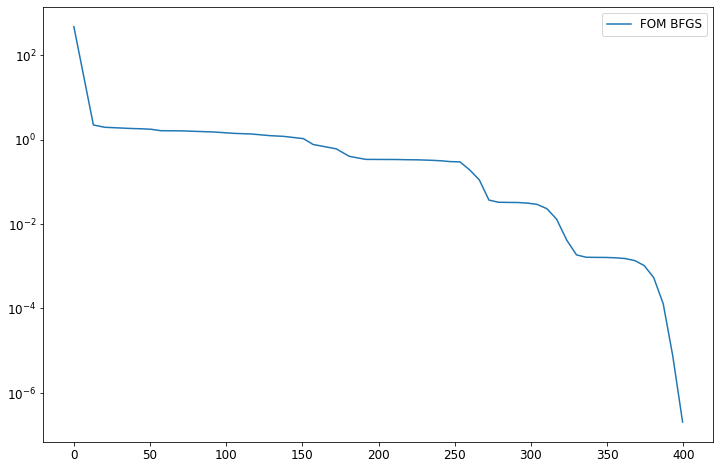

In [10]:
plt.semilogy(times_full_2,J_error_2, label='FOM BFGS')
plt.legend()

# TR approach

In [11]:
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor

from pymor.parameters.functionals import MinThetaParameterFunctional

ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

## BFGS (Lagrange-Basis)

#### NCD-Corrected Functional - Variant 3(a)

In [12]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=True)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar,
                                                            adjoint_estimate=True)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}

from pdeopt.TR import TR_algorithm

mus_23, times_23, Js_23, FOC_23 = TR_algorithm(opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_23_actual, J_error_23_actual, mu_error_23_actual, FOC_23_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_23[1:], Js_23, times_23, tictoc, FOC_23)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}
Starting value of the cost: 478.30364369621293
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 3 - Cost Functional: 90.04103900806467 - mu: {heaters: [37.266038796493014, 0.0, 51.653771169699695, 40.20657611150573, 38.598622098446214, 29.550004814065197, 7.613202354533058], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 11.049475975243373
*****************

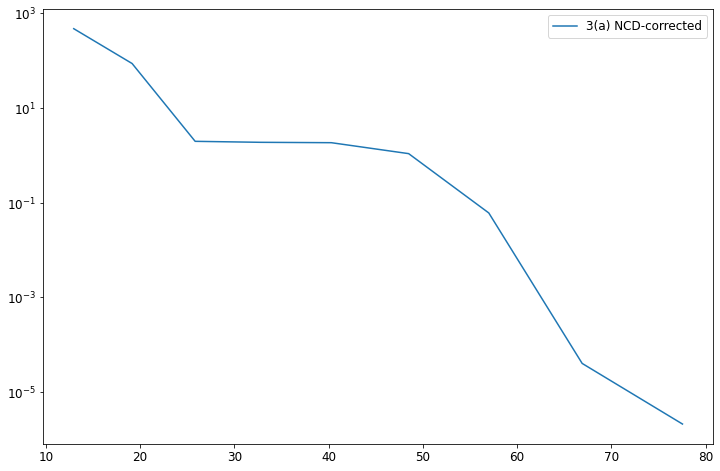

In [13]:
plt.semilogy(times_full_23_actual,J_error_23_actual, label='3(a) NCD-corrected')
plt.legend()

#### Standard approach - Variant 1(a)

In [14]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = { 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}
from pdeopt.TR import TR_algorithm
mus_25, times_25, Js_25, FOC_25 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_25_actual, J_error_25_actual, mu_error_25_actual, FOC_25_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_25[1:], Js_25, times_25, tictoc, FOC_25)


Starting with two bases. Primal and dual have length 1 and 1
starting parameter {heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}
Starting value of the cost: 478.30364369576637
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 3 - Cost Functional: 99.58150866227106 - mu: {heaters: [37.575093582797834, 0.0, 51.814502434840655, 40.36741220462538, 38.763422481766234, 29.715962860815647, 8.231782491066735], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 11.829450149272903
*****************

Subproblem converged: FOC = 0.0004557210493117978, mu_diff = 1.402358902636792e-13, J_diff = 0.0 
relative differences mu 1.402358902636792e-13 and J 0.0
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 9, 9, [] and []
k: 7 - j 5 - Cost Functional: 2.772865386217518 - mu: {heaters: [16.603561710976045, 16.975679355729667, 17.54899230762089, 17.408398500851813, 17.991169639467973, 18.107673799663722, 16.94446791932011], walls: [0.025, 0.025, 0.025]}
Shrinking the TR radius to: 0.1 because Jcp 2.7728628445904633 and J_kp1 2.772865386217518
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 0.0004557210493117978, mu_diff = 1.402358902636792e-13, J_diff = 0.0 
relative differences mu 1.402358902636792e-13 and J 0.0
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 9, 9, [] and []
k: 7 - j 5 - 

Subproblem converged: FOC = 0.00045125234436533645, mu_diff = 2.586239663956742e-14, J_diff = 0.0 
relative differences mu 2.586239663956742e-14 and J 0.0
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 10, 10, [] and []
k: 8 - j 3 - Cost Functional: 2.772865322315738 - mu: {heaters: [16.603550568974896, 16.97569594203122, 17.548970482980035, 17.40844750955758, 17.991237850764477, 18.107780953530547, 16.944560085482838], walls: [0.025, 0.025, 0.025]}
enlarging the TR radius to 0.000390625
computing the fom gradient since the model was enriched
First order critical condition: 0.0004508941252531243
******************************* 


Stopping criteria fulfilled: FOM FOC condition 0.0004508941252531243 


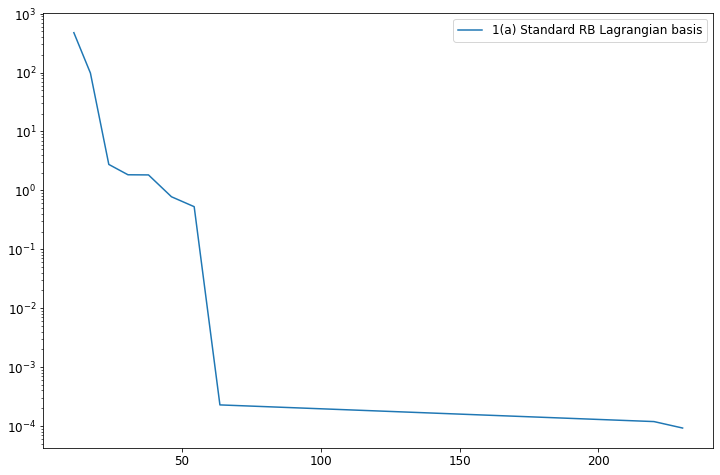

In [15]:
plt.semilogy(times_full_25_actual,J_error_25_actual, label='1(a) Standard RB Lagrangian basis')
plt.legend()

#### Qian et al. 2017 version

In [16]:
#Qian-Grepl
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product, 
                                                            coercivity_estimator=ce, mu_bar=mu_bar,
                                                            prepare_for_gradient_estimate= True)

opt_rom = pdeopt_reductor.reduce()
tictoc = time.time() - tic

TR_parameters = {'Qian-Grepl': True,
                 'beta': beta, 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i,  
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": False, 'timings': True}

mus_26, times_26,Js_26, FOC_26, opt_rom = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params, return_opt_rom=True)

times_full_26_actual, J_error_26_actual, FOC_26_actual, mu_error_26_actual = compute_actual_errors(
    opt_fom, J_start, J_opt, mus_26, times_26, tictoc, mu, mu_opt_as_array)

Starting with two bases. Primal and dual have length 1 and 1
GRAD J ESTIMATOR: non corrected estimator
QIAN et al. 2017 Method
starting parameter {heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}
Starting value of the cost: 478.30364369576637
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 0 - j 3 - Cost Functional: 99.58150866227106 - mu: {heaters: [37.575093582797834, 0.0, 51.814502434840655, 40.36741220462538, 38.763422481766234, 29.715962860815647, 8.231782491066735], walls: [0.1, 0.1, 0.1]}
estimate_gradien

Subproblem converged: FOC = 1.1965310663406058e-05, mu_diff = 3.087157325532105e-16, J_diff = 0.0 
relative differences mu 3.087157325532105e-16 and J 0.0
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 12, 12, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 10 - j 24 - Cost Functional: 2.7727719393910775 - mu: {heaters: [16.51451695467497, 16.930975147300405, 17.327087238169135, 17.47068956463887, 18.124392964660554, 18.408820360561112, 16.93340684099209], walls: [0.025, 0.025, 0.025]}
estimate_gradient 9.333570731376408e-06
First order critical condition: 1.9247023260822963e-05
******************************* 


Stopping criteria fulfilled: normgrad 1.9247023260822963e-05 + estimate_gradient 9.333570731376408e-06
computing actual errors .... 


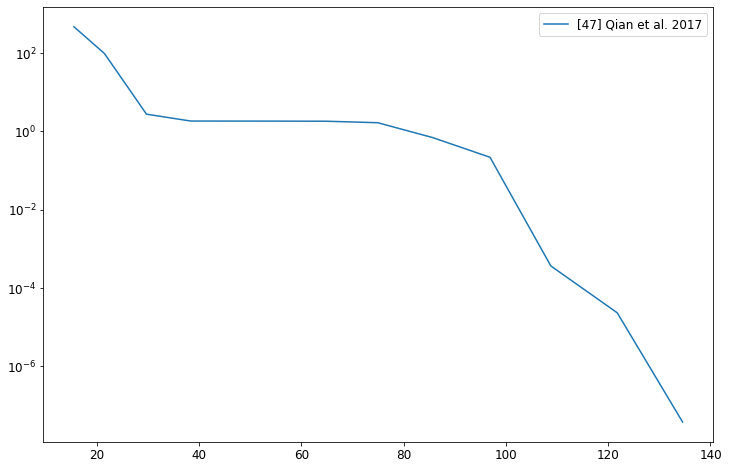

In [17]:
plt.semilogy(times_full_26_actual,J_error_26_actual, label='[47] Qian et al. 2017')
plt.legend()

#### semi NCD-corrected (Variant 2a)

In [18]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_39, times_39, Js_39, FOC_39 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_39_actual, J_error_39_actual, mu_error_39_actual, FOC_39_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_39[1:], Js_39, times_39, tictoc, FOC_39)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}
Starting value of the cost: 478.30364369621293
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 3 - Cost Functional: 92.16798145434745 - mu: {heaters: [37.330097462502145, 0.0, 51.68580329485972, 40.23858411752725, 38.63028036029123, 29.581357044201958, 7.739164928092262], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 11.207851808569568
*******************

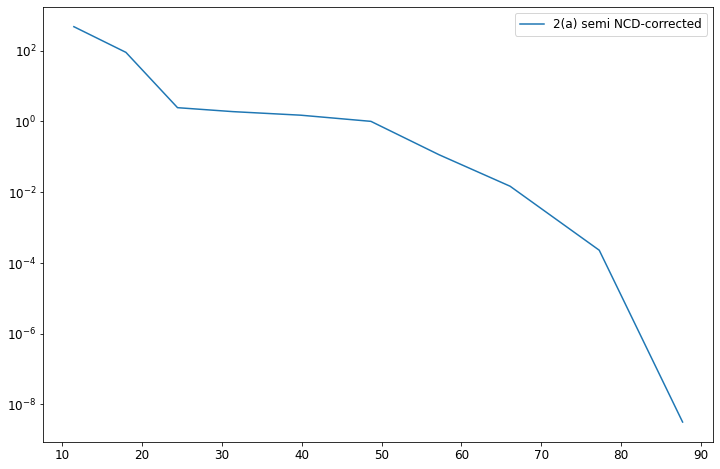

In [19]:
plt.semilogy(times_full_39_actual,J_error_39_actual, label='2(a) semi NCD-corrected')
plt.legend()

## TR BFGS - Single Basis - Variant 1(b)

In [20]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                        RBbasis, dual_RBbasis, 
                                                        opt_product=opt_fom.opt_product,
                                                        coercivity_estimator=ce,
                                                        unique_basis=True,
                                                        mu_bar=mu_bar,
                                                        true_lagrange=False)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic


TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_54, times_54, Js_54, FOC_54 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_54_actual, J_error_54_actual, mu_error_54_actual, FOC_54_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_54[1:], Js_54, times_54, tictoc, FOC_54)

Starting with only one basis with length 2
starting parameter {heaters: [43.59949021420037, 2.5926231827891333, 54.96624778787091, 43.53223926182769, 42.0367802087489, 33.03348210038741, 20.46486340378425], walls: [0.07144532247629978, 0.047474100525589244, 0.045012045632715006]}
Starting value of the cost: 478.3036436956545
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Length of Basis is 4
k: 0 - j 1 - Cost Functional: 86.6329388047725 - mu: {heaters: [37.182436911088686, 0.0, 51.61340749349508, 40.162045294509966, 38.5501322018237, 29.49697425548388, 7.39413246442315], walls: [0.1, 0.1, 0.1]}
Shrinking the TR radius to: 0.05 because Jcp 86.51098066639133 and J_kp1 86.6329388047725
******************************* 

___ starting subproblem
Computing the approximate Cauchy point a

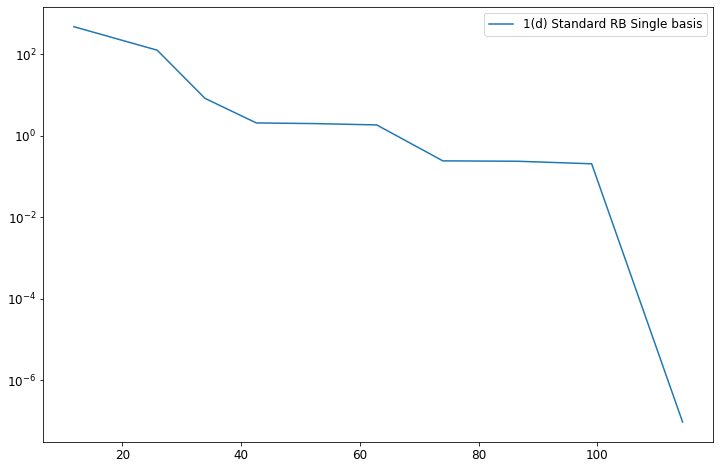

In [21]:
plt.semilogy(times_full_54_actual,J_error_54_actual, label='1(d) Standard RB Single basis')
plt.legend()

# Results

{heaters: [16.5189198646, 16.92820877511, 17.32387911116, 17.4695122784, 18.12299797114, 18.40759241105, 16.93448657882], walls: [0.025, 0.025, 0.025]}


<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f3704417ad0>

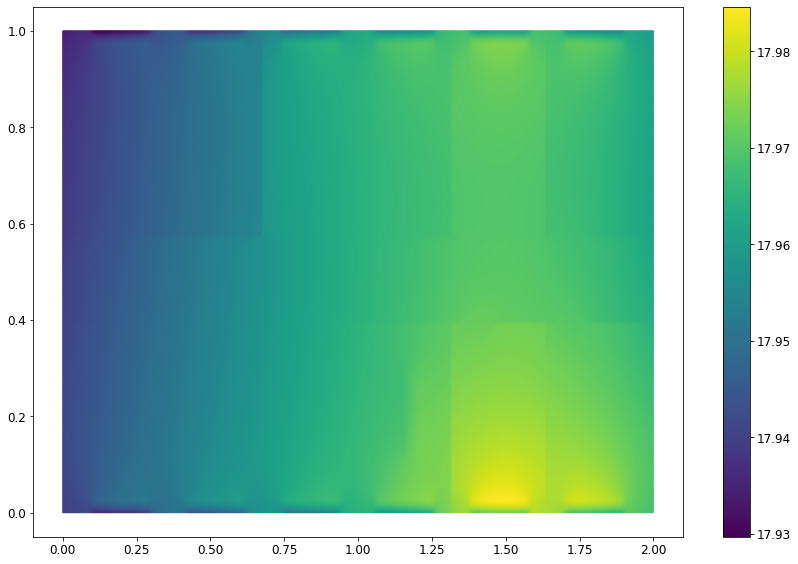

In [22]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

In [23]:
u = opt_fom.solve(mu_opt)
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    empty_bi = EmptyBoundaryInfo(data['grid'])
    u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
    diff= u.to_numpy()-u_d.to_numpy()
    diff_= opt_fom.solution_space.from_numpy(diff)
    Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

6.477934887508911e-05
[[1.71324989e-06]]


## Plot results

### J error

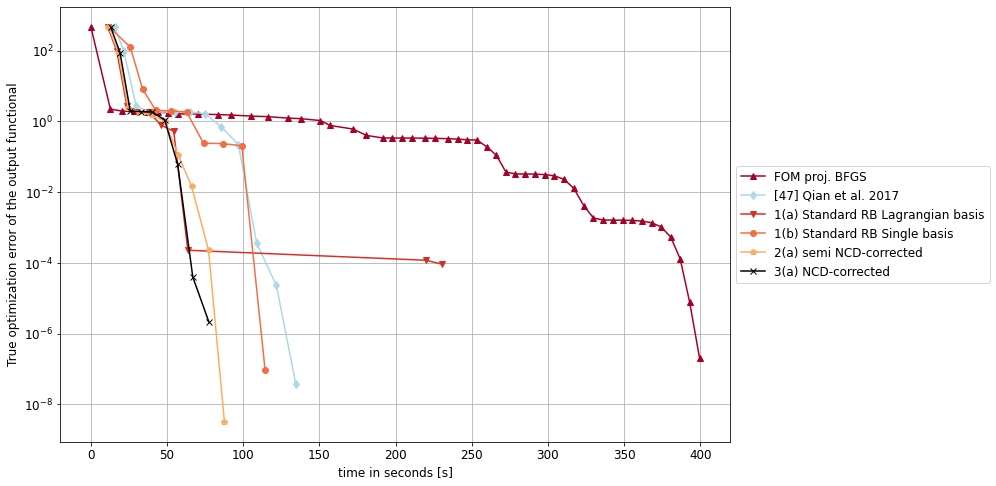

In [24]:
timings_figure = plt.figure()

color0 = (0.65,0,0.15)
color1 = (0.84,0.19,0.15)
color2 = (0.96,0.43,0.26)
color3 = (0.99,0.68,0.38)
color5 = (0.67,0.85,0.91)

#FOM
plt.semilogy(times_full_2,J_error_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,J_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,J_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,J_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,J_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,J_error_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot FOC

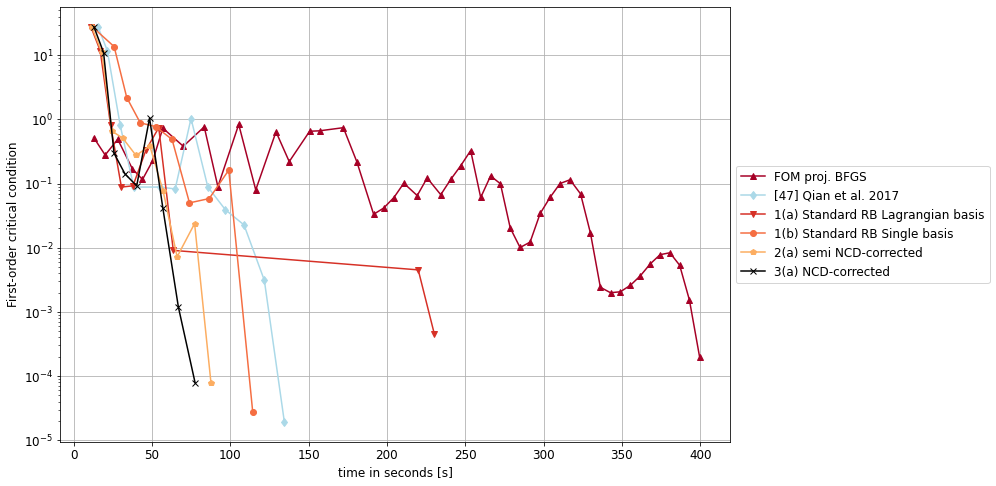

In [25]:
timings_figure = plt.figure()

#FOM
plt.semilogy(times_full_2[1:],FOC_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,FOC_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,FOC_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,FOC_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,FOC_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,FOC_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot Mu error

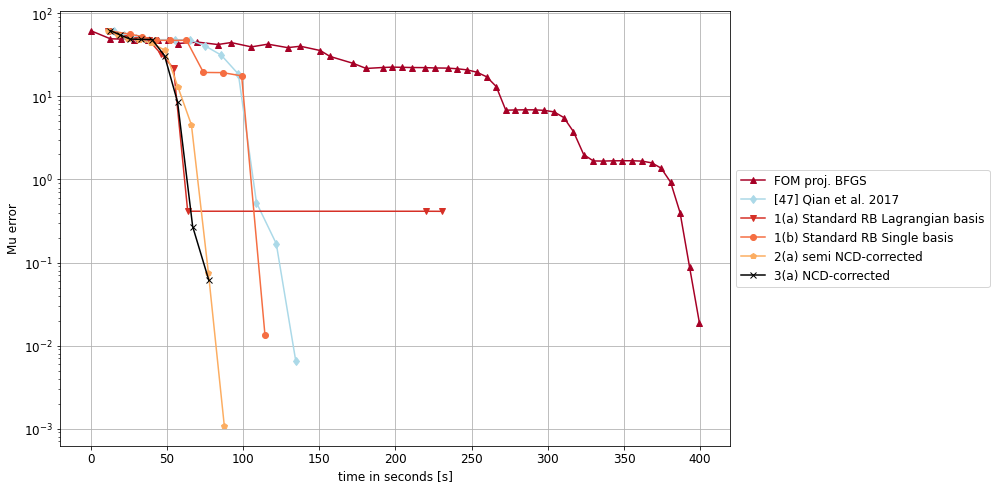

In [26]:
if mu_opt is not None:
    timings_figure = plt.figure()
    
    #FOM
    plt.semilogy(times_full_2,mu_error_2,'^-', color=color0, label='FOM proj. BFGS')

    # Qian et al. 2017
    plt.semilogy(times_full_26_actual,mu_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

    # Lagrange Basis
    plt.semilogy(times_full_25_actual,mu_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

    # Unique Basis
    plt.semilogy(times_full_54_actual,mu_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

    # Lagrange Basis
    plt.semilogy(times_full_39_actual,mu_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
    plt.semilogy(times_full_23_actual,mu_error_23_actual,'x-k', label='3(a) NCD-corrected')

    plt.xlabel('time in seconds [s]')
    plt.ylabel('Mu error')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the data

In [27]:
#save data
from pdeopt.tools import save_data
directory = './results/Starter2'
save_data(directory, times_full_2, J_error_2, 2, mu_error=mu_error_2, FOC=FOC_2)
save_data(directory, times_full_23_actual, J_error_23_actual, 23, mu_error=mu_error_23_actual, FOC=FOC_23_actual)
save_data(directory, times_full_25_actual, J_error_25_actual, 25, mu_error=mu_error_25_actual, FOC=FOC_25_actual)
save_data(directory, times_full_26_actual, J_error_26_actual, 26, mu_error=mu_error_26_actual, FOC=FOC_26_actual)
save_data(directory, times_full_39_actual, J_error_39_actual, 39, mu_error=mu_error_39_actual, FOC=FOC_39_actual)
save_data(directory, times_full_54_actual, J_error_54_actual, 54, mu_error=mu_error_54_actual, FOC=FOC_54_actual)